In [1]:
#Setting up the code and installing required packages 
%load_ext autotime
from util import *
from glob import glob
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import LineString, Polygon
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
from shapelysmooth import taubin_smooth
import shutil
pd.set_option("display.max_columns", None)

In [9]:
#Input intersects shapefile 

site="NorthIsland"
gdf = gpd.read_file(f"Data/Merged Intersects_UniqueID_Proxy/NorthIsland_Intersects_Proxy.shp")

In [10]:
#Setting the year data will be projected to. Currently 2100
gdf["Date"] = pd.to_datetime(gdf.ShorelineI, dayfirst=True, format='mixed')
gdf["Year"] = gdf.Date.dt.year
gdf["YearsSinceBase"] = (gdf.Date - pd.Timestamp(1800, 1, 1)).dt.days / 365.25
gdf["YearsUntilFuture"] = (
    pd.Timestamp(2100, 1, 1) - gdf.Date
    ).dt.days / 365.25
gdf.Date = gdf.Date.astype(str)
gdf["TransectID"] = gdf.Unique_ID.astype(np.int64)
gdf

,Join_Count,TARGET_FID,ShorelineI,BaselineID,Distance,IntersectX,IntersectY,Uncertaint,Unique_ID,Date,Region,Site,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,USDate,SHLength,Date_1,ID,geometry,Year,YearsSinceBase,YearsUntilFuture,TransectID
0,1,0,01/03/2011,0.0,-37.16,1.730591e+06,5.908710e+06,8.59,1.006327e+11,2011-03-01,Auckland,KarekareBethells,MW,1000,tod,LDS,5,1,0,0.00,0.075000,8.590327,01/03/2011,0.716680,2011/01/03,57.0,POINT Z (1730590.982 5908710.362 0),2011,211.156742,88.837782,100632729920
1,1,1,08/19/1960,0.0,-51.70,1.730600e+06,5.908699e+06,3.76,1.006327e+11,1960-08-19,Auckland,KarekareBethells,MW,2000,tod,RL,3,1,16700,3.61,0.433284,3.763075,08/19/1960,0.702465,1960/08/19,20.0,POINT Z (1730600.339 5908699.234 0),1960,160.626968,139.367556,100632729920
2,1,2,01/04/2017,0.0,-32.09,1.730588e+06,5.908714e+06,2.94,1.006327e+11,2017-04-01,Auckland,KarekareBethells,MW,1000,tod,VHR,4,1,0,2.02,0.500000,2.935183,01/04/2017,0.730413,2017/01/04,67.0,POINT Z (1730587.72 5908714.241 0),2017,217.242984,82.751540,100632729920
3,1,3,01/02/2004,0.0,-48.27,1.730598e+06,5.908702e+06,10.05,1.006327e+11,2004-02-01,Auckland,KarekareBethells,MW,3000,tod,RL,5,1,40000,5.03,1.416425,10.054614,01/02/2004,0.658490,2004/01/02,6.0,POINT Z (1730598.132 5908701.858 0),2004,204.079398,95.915127,100632729920
4,0,4,01/04/2022,0.0,-23.18,1.730582e+06,5.908721e+06,2.07,1.006327e+11,2022-04-01,None,None,None,0,None,None,0,0,0,0.00,0.000000,0.000000,None,0.000000,0000/00/00,0.0,POINT Z (1730581.983 5908721.063 0),2022,222.242300,77.752225,100632729920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914496,1,914496,02/21/2021,0.0,-104.61,1.800540e+06,5.395670e+06,1.02,1.004660e+11,2021-02-21,Wellington,WhiteRock,MD,1000,None,LDS,3,1,0,0.00,0.300000,1.015332,02/21/2021,1.539728,2021/02/21,18786.0,POINT Z (1800539.73 5395670.271 0),2021,221.136208,78.858316,100466049969
914497,1,914497,09/24/1995,0.0,-69.89,1.800538e+06,5.395636e+06,5.64,1.004660e+11,1995-09-24,Wellington,WhiteRock,MD,2000,None,RL,4,1,52000,5.00,1.500000,5.642322,09/24/1995,0.547704,1995/09/24,18792.0,POINT Z (1800538.365 5395635.582 0),1995,195.723477,104.271047,100466049969
914498,1,914498,04/12/1973,0.0,-46.92,1.800527e+06,5.395613e+06,4.73,1.004661e+11,1973-12-04,Wellington,WhiteRock,MD,2000,None,RL,4,1,23900,4.00,0.700000,4.734438,04/12/1973,1.494543,1973/04/12,18772.0,POINT Z (1800527.469 5395613.018 0),1973,173.919233,126.075291,100466050980
914499,1,914499,02/21/2021,0.0,-104.80,1.800530e+06,5.395671e+06,1.02,1.004661e+11,2021-02-21,Wellington,WhiteRock,MD,1000,None,LDS,3,1,0,0.00,0.300000,1.015332,02/21/2021,1.539728,2021/02/21,18786.0,POINT Z (1800529.745 5395670.85 0),2021,221.136208,78.858316,100466050980


In [43]:
gdf.groupby("TransectID").size().value_counts()

5     25459
6     23394
4     22273
3     16393
7     13744
8     12216
9      5543
10     4268
13     3071
11     2709
12     2356
14     2044
16     1440
17     1372
18     1144
15     1096
20      356
19      259
21        1
Name: count, dtype: int64

<Axes: >

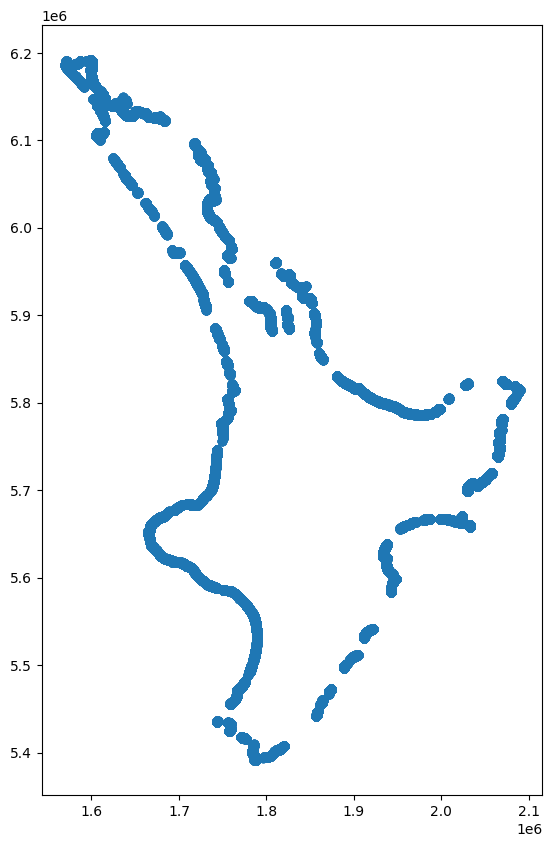

In [59]:
good = gdf.groupby("TransectID").Proxy.nunique() == 1
good_transects = good[good].index
gdf[gdf.TransectID.isin(good_transects)].plot(figsize=(10,10))

In [21]:
sum(gdf.groupby("TransectID").Proxy.nunique() == 1) / 139138

0.8085569722146358

In [11]:
gdf.Proxy.value_counts()

Proxy
1    719041
4     79421
2     47976
3     43354
6     10274
5      9572
0      4863
Name: count, dtype: int64

In [24]:
proxies_at_transect = gdf.groupby("TransectID").Proxy.apply(lambda proxies: ",".join(str(i) for i in sorted(proxies.unique())))
proxies_at_transect.value_counts()

Proxy
1            89548
1,3           9732
4             9106
2             9015
1,4           6354
3             4705
1,5           2809
1,2           1933
0,1           1558
1,3,4         1259
1,6           1077
1,2,3          564
3,4            284
1,4,6          250
0,1,5          163
5              127
2,4            104
0,1,3           81
1,3,4,5         74
1,4,5           71
2,3             64
1,5,6           63
4,5             48
1,2,3,4         36
0,2             27
1,3,6           27
0,1,4            9
0,4              8
0,3              7
1,2,3,6          6
0,1,3,4          5
1,2,4            5
0,1,2,3          5
0,1,2            4
0,1,6            4
0,3,4            3
0,1,4,6          1
0,5              1
0,1,2,3,4        1
Name: count, dtype: int64

In [26]:
proxies_at_transect[proxies_at_transect == "1,3"]

TransectID
100000207668    1,3
100000208692    1,3
100000213524    1,3
100000214727    1,3
100000215727    1,3
               ... 
100787676552    1,3
100787677554    1,3
100787678554    1,3
100787679561    1,3
100787680580    1,3
Name: Proxy, Length: 9732, dtype: object

In [54]:
sample = gdf[gdf.TransectID == 100000207668]
display(gdf[gdf.distance(sample.geometry.iloc[0]) < 100].Proxy.value_counts())
gdf[gdf.distance(sample.geometry.iloc[0]) < 100].explore("Proxy", legend=True, tiles="Esri.WorldImagery")

Proxy
1    13
3     6
Name: count, dtype: int64

In [32]:
gdf[gdf.TransectID == 100736052932].explore(tiles="Esri.WorldImagery")

In [4]:
def get_transects(intersects):
  p1 = intersects.geometry[intersects.Distance.idxmin()].coords[0]
  p2 = intersects.geometry[intersects.Distance.idxmax()].coords[0]
  azimuth = math.degrees(math.atan2(p1[0]-p2[0], p1[1]-p2[1]))
  if azimuth < 0:
      azimuth += 360
  return pd.Series({"Azimuth": azimuth, "geometry": LineString([p1, p2])})

lines = gdf.groupby("TransectID")[["geometry", "Distance"]].apply(get_transects)
lines.crs = gdf.crs
lines

,Azimuth,geometry
TransectID,,
201000006218,258.690068,"LINESTRING Z (1602185.33 5445755.803 0, 160221..."
201000007220,258.690068,"LINESTRING Z (1602188.813 5445746.302 0, 16022..."
201000008225,258.690068,"LINESTRING Z (1602192.24 5445736.789 0, 160221..."
201000009230,258.690068,"LINESTRING Z (1602195.33 5445727.209 0, 160221..."
201000010239,258.690068,"LINESTRING Z (1602196.461 5445717.237 0, 16022..."
...,...,...
201000233653,274.085617,"LINESTRING Z (1603305.544 5443845.332 0, 16033..."
201000234444,287.241460,"LINESTRING Z (1603305.544 5443845.913 0, 16033..."
201000234674,274.085617,"LINESTRING Z (1603304.318 5443835.394 0, 16033..."


In [5]:
#Set the extrapolation distance between intersects. Currently set to 20m
lines["dist_to_neighbour"] = lines.distance(lines.shift(-1))
breakpoints = lines.dist_to_neighbour[lines.dist_to_neighbour > 20]
lines["group"] = pd.Series(range(len(breakpoints)), index=breakpoints.index)
lines["group"] = lines.group.bfill().fillna(len(breakpoints)).astype(int)
transect_metadata = lines[["Azimuth", "group"]].to_dict(orient="index")
transect_metadata

{201000006218: {'Azimuth': 258.6900675249549, 'group': 0},
 201000007220: {'Azimuth': 258.69006752786225, 'group': 0},
 201000008225: {'Azimuth': 258.6900681804391, 'group': 0},
 201000009230: {'Azimuth': 258.6900675252886, 'group': 0},
 201000010239: {'Azimuth': 258.6900675268282, 'group': 0},
 201000012112: {'Azimuth': 238.55128489231237, 'group': 1},
 201000013122: {'Azimuth': 238.55128571432044, 'group': 1},
 201000014130: {'Azimuth': 238.55128432263012, 'group': 1},
 201000015137: {'Azimuth': 238.55128432319822, 'group': 1},
 201000016143: {'Azimuth': 238.5512843218965, 'group': 1},
 201000017149: {'Azimuth': 238.55128489223875, 'group': 1},
 201000018155: {'Azimuth': 238.55128628350332, 'group': 1},
 201000019161: {'Azimuth': 238.5512843217919, 'group': 1},
 201000019767: {'Azimuth': 245.07152607707573, 'group': 1},
 201000020767: {'Azimuth': 245.0715260770204, 'group': 1},
 201000021767: {'Azimuth': 245.071526077383, 'group': 1},
 201000022768: {'Azimuth': 245.07152547213863, 'g

In [6]:
linear_models = fit(gdf, transect_metadata)
linear_models

,TransectID,slope,intercept,group,r2_score,mae,mse,rmse
0,201000006218,0.141150,-82.918686,0,0.268150,5.411194,38.018848,6.165943
1,201000007220,0.157336,-86.694477,0,0.342575,5.209630,33.215158,5.763259
2,201000008225,0.177292,-91.054082,0,0.410147,5.077690,31.606213,5.621940
3,201000009230,0.201853,-96.181599,0,0.462914,5.061075,33.052558,5.749135
4,201000010239,0.231558,-102.023063,0,0.501750,5.368819,37.228017,6.101477
...,...,...,...,...,...,...,...,...
178,201000233653,-0.142888,-43.510724,3,0.102303,8.237149,125.263260,11.192107
179,201000234444,-0.148141,-43.023745,3,0.103245,8.401957,133.275152,11.544486
180,201000234674,-0.150455,-44.532273,3,0.103355,8.839343,137.308119,11.717855
181,201000235445,-0.163733,-40.195126,3,0.111552,8.961957,149.286022,12.218266


In [7]:
results = predict(gdf, linear_models, transect_metadata)
results.set_geometry("linear_model_point", inplace=True, crs=2193)
results

,TransectID,slope,intercept,group,r2_score,mae,mse,rmse,BaselineID,Year,ocean_point,linear_model_point,linear_model_predicted_distance,linear_model_distance,sqrt_model_point,sqrt_model_predicted_distance,sqrt_model_distance,BH_model_point,BH_model_predicted_distance,BH_model_distance,Sunamura_model_point,Sunamura_model_predicted_distance,Sunamura_model_distance
0,2.010000e+11,0.141150,-82.918686,0.0,0.268150,5.411194,38.018848,6.165943,1.0,2100,POINT (1602697.1008380533 5445858.157424874),POINT (1602194.862 5445757.71),-60.334625,12.184625,POINT (1602222.2358266069 5445763.184422576),-32.419192,-15.730808,POINT (1602160.0221558656 5445750.741688427),-95.864936,47.714936,POINT (1602184.0841244073 5445755.554082135),-71.326447,23.176447
1,2.010000e+11,0.157336,-86.694477,0.0,0.342575,5.209630,33.215158,5.763259,1.0,2100,POINT (1602700.2877252528 5445848.59676326),POINT (1602195.661 5445747.671),-61.520792,14.620792,POINT (1602226.1726476622 5445753.773747758),-30.404406,-16.495594,POINT (1602160.8201849158 5445740.703255211),-97.051103,50.151103,POINT (1602184.880032262 5445745.515224679),-72.514777,25.614777
2,2.010000e+11,0.177292,-91.054082,0.0,0.410147,5.077690,31.606213,5.621940,1.0,2100,POINT (1602703.1610996271 5445838.973393835),POINT (1602196.478 5445737.637),-62.687397,16.717397,POINT (1602230.860252295 5445744.513229979),-27.624246,-18.345754,POINT (1602161.6376680029 5445730.668713943),-98.217708,52.247708,POINT (1602185.6948999763 5445735.480160052),-73.684049,27.714049
3,2.010000e+11,0.201853,-96.181599,0.0,0.462914,5.061075,33.052558,5.749135,1.0,2100,POINT (1602706.0136969849 5445829.345879575),POINT (1602197.264 5445727.596),-63.885105,18.825105,POINT (1602236.4092542387 5445735.42499102),-23.964443,-21.095557,POINT (1602162.4234888158 5445720.6278379345),-99.415416,54.355416,POINT (1602186.4775017765 5445725.438640527),-74.885039,29.825039
4,2.010000e+11,0.231558,-102.023063,0.0,0.501750,5.368819,37.228017,6.101477,1.0,2100,POINT (1602709.399396347 5445819.824980407),POINT (1602198.16 5445717.577),-64.973852,21.363852,POINT (1602243.0661066815 5445726.558322481),-19.178509,-24.431491,POINT (1602163.3197421436 5445710.6090495745),-100.504163,56.894163,POINT (1602187.3698620922 5445715.419073564),-75.977756,32.367756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,2.010002e+11,-0.142888,-43.510724,3.0,0.102303,8.237149,125.263260,11.192107,3.0,2100,POINT (1603813.2790788254 5443809.065187531),POINT (1603328.152 5443843.717),-66.372825,-13.637175,POINT (1603299.964951812 5443845.7304814635),-94.631936,14.621936,POINT (1603292.7122304742 5443846.248532975),-101.903135,21.893135,POINT (1603317.2262265142 5443844.497533299),-77.326683,-2.683317
179,2.010002e+11,-0.148141,-43.023745,3.0,0.103245,8.401957,133.275152,11.544486,3.0,2100,POINT (1603791.7387139841 5443695.02528319),POINT (1603327.189 5443839.196),-66.726348,-13.593652,POINT (1603299.2079599637 5443847.879658238),-96.024376,15.704376,POINT (1603293.2557306513 5443849.726901855),-102.256659,21.936659,POINT (1603316.7284892467 5443842.442252488),-77.679504,-2.640496
180,2.010002e+11,-0.150455,-44.532273,3.0,0.103355,8.839343,137.308119,11.717855,3.0,2100,POINT (1603809.8078799683 5443799.287652555),POINT (1603325.217 5443833.901),-68.605090,-14.174910,POINT (1603295.5373976459 5443836.0212575765),-98.360728,15.580728,POINT (1603289.7774002426 5443836.432685953),-104.135400,21.355400,POINT (1603314.2924050654 5443834.681614221),-79.557937,-3.222063
181,2.010002e+11,-0.163733,-40.195126,3.0,0.111552,8.961957,149.286022,12.218266,3.0,2100,POINT (1603788.1730199924 5443685.661381762),POINT (1603324.544 5443829.546),-66.392452,-14.557548,POINT (1603293.6177657864 5443839.144043951),-98.774128,17.824128,POINT (1603290.610617441 5443840.077296869),-101.922763,20.972763,POINT (1603314.0853664028 5443832.792030088),-77.343524,-3.606476


In [8]:
#Line and polygon shapefiles are created here 
def prediction_results_to_line_polygon(results: gpd.GeoDataFrame):
    lines = []
    polygons = []
    for group_name, group_data in results.groupby(["BaselineID", "group"]):
        if len(group_data) > 1:
            line = LineString(list(group_data.geometry))
            lines.append(line)
            polygon = Polygon(list(group_data.geometry) + list(group_data.ocean_point)[::-1])
            polygons.append(polygon)
    lines = gpd.GeoSeries(lines, crs=2193)
    polygons = gpd.GeoSeries(polygons, crs=2193)
    return lines, polygons
lines, poly = prediction_results_to_line_polygon(results)

In [9]:
#Smoothening occurs here. Currently 500 steps of Taubin's algorithm applied. Change the file name and location accordingly.  
m = lines.explore()
lines.apply(lambda line: taubin_smooth(line, steps=500)).to_file("Projections/JackettIsland_output_line_smoothed.shp")
lines.apply(lambda line: taubin_smooth(line, steps=500)).explore(m=m, color="red")

In [12]:
results

,TransectID,slope,intercept,group,r2_score,mae,mse,rmse,BaselineID,Year,ocean_point,linear_model_point,linear_model_predicted_distance,linear_model_distance,sqrt_model_point,sqrt_model_predicted_distance,sqrt_model_distance,BH_model_point,BH_model_predicted_distance,BH_model_distance,Sunamura_model_point,Sunamura_model_predicted_distance,Sunamura_model_distance
0,2.010000e+11,0.141150,-82.918686,0.0,0.268150,5.411194,38.018848,6.165943,1.0,2100,POINT (1602697.1008380533 5445858.157424874),POINT (1602194.862 5445757.71),-60.334625,12.184625,POINT (1602222.2358266069 5445763.184422576),-32.419192,-15.730808,POINT (1602160.0221558656 5445750.741688427),-95.864936,47.714936,POINT (1602184.0841244073 5445755.554082135),-71.326447,23.176447
1,2.010000e+11,0.157336,-86.694477,0.0,0.342575,5.209630,33.215158,5.763259,1.0,2100,POINT (1602700.2877252528 5445848.59676326),POINT (1602195.661 5445747.671),-61.520792,14.620792,POINT (1602226.1726476622 5445753.773747758),-30.404406,-16.495594,POINT (1602160.8201849158 5445740.703255211),-97.051103,50.151103,POINT (1602184.880032262 5445745.515224679),-72.514777,25.614777
2,2.010000e+11,0.177292,-91.054082,0.0,0.410147,5.077690,31.606213,5.621940,1.0,2100,POINT (1602703.1610996271 5445838.973393835),POINT (1602196.478 5445737.637),-62.687397,16.717397,POINT (1602230.860252295 5445744.513229979),-27.624246,-18.345754,POINT (1602161.6376680029 5445730.668713943),-98.217708,52.247708,POINT (1602185.6948999763 5445735.480160052),-73.684049,27.714049
3,2.010000e+11,0.201853,-96.181599,0.0,0.462914,5.061075,33.052558,5.749135,1.0,2100,POINT (1602706.0136969849 5445829.345879575),POINT (1602197.264 5445727.596),-63.885105,18.825105,POINT (1602236.4092542387 5445735.42499102),-23.964443,-21.095557,POINT (1602162.4234888158 5445720.6278379345),-99.415416,54.355416,POINT (1602186.4775017765 5445725.438640527),-74.885039,29.825039
4,2.010000e+11,0.231558,-102.023063,0.0,0.501750,5.368819,37.228017,6.101477,1.0,2100,POINT (1602709.399396347 5445819.824980407),POINT (1602198.16 5445717.577),-64.973852,21.363852,POINT (1602243.0661066815 5445726.558322481),-19.178509,-24.431491,POINT (1602163.3197421436 5445710.6090495745),-100.504163,56.894163,POINT (1602187.3698620922 5445715.419073564),-75.977756,32.367756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,2.010002e+11,-0.142888,-43.510724,3.0,0.102303,8.237149,125.263260,11.192107,3.0,2100,POINT (1603813.2790788254 5443809.065187531),POINT (1603328.152 5443843.717),-66.372825,-13.637175,POINT (1603299.964951812 5443845.7304814635),-94.631936,14.621936,POINT (1603292.7122304742 5443846.248532975),-101.903135,21.893135,POINT (1603317.2262265142 5443844.497533299),-77.326683,-2.683317
179,2.010002e+11,-0.148141,-43.023745,3.0,0.103245,8.401957,133.275152,11.544486,3.0,2100,POINT (1603791.7387139841 5443695.02528319),POINT (1603327.189 5443839.196),-66.726348,-13.593652,POINT (1603299.2079599637 5443847.879658238),-96.024376,15.704376,POINT (1603293.2557306513 5443849.726901855),-102.256659,21.936659,POINT (1603316.7284892467 5443842.442252488),-77.679504,-2.640496
180,2.010002e+11,-0.150455,-44.532273,3.0,0.103355,8.839343,137.308119,11.717855,3.0,2100,POINT (1603809.8078799683 5443799.287652555),POINT (1603325.217 5443833.901),-68.605090,-14.174910,POINT (1603295.5373976459 5443836.0212575765),-98.360728,15.580728,POINT (1603289.7774002426 5443836.432685953),-104.135400,21.355400,POINT (1603314.2924050654 5443834.681614221),-79.557937,-3.222063
181,2.010002e+11,-0.163733,-40.195126,3.0,0.111552,8.961957,149.286022,12.218266,3.0,2100,POINT (1603788.1730199924 5443685.661381762),POINT (1603324.544 5443829.546),-66.392452,-14.557548,POINT (1603293.6177657864 5443839.144043951),-98.774128,17.824128,POINT (1603290.610617441 5443840.077296869),-101.922763,20.972763,POINT (1603314.0853664028 5443832.792030088),-77.343524,-3.606476


In [22]:
#Saving line and polygon projection file to folder in VS Code. Change file location accordingly
shutil.rmtree("Projections")

for model in SUPPORTED_MODELS:
    results.set_geometry(f"{model}_model_point", inplace=True, crs=2193)
    lines, polygon = prediction_results_to_line_polygon(results)
    os.makedirs("Projections", exist_ok=True)
    polygon.to_file(f"Projections/{site}_{model}_polygon.shp")
    lines.to_file(f"Projections/{site}_{model}_line.shp")

    #Smoothening occurs here. Currently 500 steps of Taubin's algorithm applied. Change the file name and location accordingly.  
    lines.apply(lambda line: taubin_smooth(line, steps=500)).to_file(f"Projections/{site}_line_smoothed.shp")


In [11]:
#Quick visualisation of projected polygon and historic shorelines 
m = poly.explore(tiles="Esri.WorldImagery")
gpd.GeoDataFrame(results.drop(columns=["ocean_point", "linear_model_point"]), geometry=results.linear_model_point).explore(m=m)
gdf.explore("Year", legend=True, m=m)